### Imports

In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta, date
import uuid
import matplotlib.pyplot as plt
import matplotlib
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import Polygon as Polygon2
# import contextily as ctx
from sklearn.cluster import KMeans
import folium
from glob import glob
from sqlalchemy import create_engine

### Helper Functions

In [33]:
def get_one_day(df, date):
    return df[df['Date'] == date].copy()

def get_dates_list(st_date,end_date):
    dates = []
    start = datetime.datetime.strptime(st_date, "%Y-%m-%d")
    end = datetime.datetime.strptime(end_date, "%Y-%m-%d")
    date_array = (start + datetime.timedelta(days=x) for x in range(0, (end-start).days+1))
    for date_object in date_array:
        dates.append(date_object.strftime("%Y-%m-%d"))
    return dates

def get_many_days(df, dates):
    eachday = []
    for i in dates:
        eachday.append(df[df['Date']==i])
    return pd.concat(eachday,ignore_index=True)

def compute_haverstine(df, lat1, long1, lat2, long2):
    # Compute distance between two points
    # https://stackoverflow.com/questions/25767596/vectorised-haversine-formula-with-a-pandas-dataframe
    df['lat_rad'], df['lng_rad'] = np.radians(df[lat1]), np.radians(df[long1])
    
    df['dLON'] = df['lng_rad'] - np.radians(df[long2])
    df['dLAT'] = df['lat_rad'] - np.radians(df[lat2])
    df['distance_km'] = 6367 * 2 * np.arcsin(np.sqrt(np.sin(df['dLAT']/2)**2 +\
                                                  np.cos(np.radians(df[lat2])) * 
                                                  np.cos(df['lat_rad']) * 
                                                  np.sin(df['dLON']/2)**2))
    
    df['distance_miles'] = df['distance_km'] * 0.621371
    df.drop(['dLON', 'dLAT', 'distance_km', 'lat_rad', 'lng_rad'], axis=1, inplace = True)
    return df.copy()

def get_bearing(p1, p2):
    # credit: https://medium.com/@bobhaffner/folium-lines-with-arrows-25a0fe88e4e
    '''
    Returns compass bearing from p1 to p2
    
    Parameters
    p1 : namedtuple with lat lon
    p2 : namedtuple with lat lon
    
    Return
    compass bearing of type float
    
    Notes
    Based on https://gist.github.com/jeromer/2005586
    '''
    
    long_diff = np.radians(p2.lon - p1.lon)
    
    lat1 = np.radians(p1.lat)
    lat2 = np.radians(p2.lat)
    
    x = np.sin(long_diff) * np.cos(lat2)
    y = (np.cos(lat1) * np.sin(lat2) 
        - (np.sin(lat1) * np.cos(lat2) 
        * np.cos(long_diff)))
    bearing = np.degrees(np.arctan2(x, y))
    
    # adjusting for compass bearing
    if bearing < 0:
        return bearing + 360
    return bearing

def get_arrows(locations, color='blue', size=6, n_arrows=3):
    from collections import namedtuple
    # credit: https://medium.com/@bobhaffner/folium-lines-with-arrows-25a0fe88e4e
    '''
    Get a list of correctly placed and rotated 
    arrows/markers to be plotted
    
    Parameters
    locations : list of lists of lat lons that represent the 
                start and end of the line. 
                eg [[41.1132, -96.1993],[41.3810, -95.8021]]
    arrow_color : default is 'blue'
    size : default is 6
    n_arrows : number of arrows to create.  default is 3
    Return
    list of arrows/markers
    '''
    
    Point = namedtuple('Point', field_names=['lat', 'lon'])
    
    # creating point from our Point named tuple
    p1 = Point(locations[0][0], locations[0][1])
    p2 = Point(locations[1][0], locations[1][1])
    
    # getting the rotation needed for our marker.  
    # Subtracting 90 to account for the marker's orientation
    # of due East(get_bearing returns North)
    rotation = get_bearing(p1, p2) - 90
    
    # get an evenly space list of lats and lons for our arrows
    # note that I'm discarding the first and last for aesthetics
    # as I'm using markers to denote the start and end
    arrow_lats = np.linspace(p1.lat, p2.lat, n_arrows + 2)[1:n_arrows+1]
    arrow_lons = np.linspace(p1.lon, p2.lon, n_arrows + 2)[1:n_arrows+1]
    
    arrows = []
    
    #creating each "arrow" and appending them to our arrows list
    for points in zip(arrow_lats, arrow_lons):
        arrows.append(folium.RegularPolygonMarker(location=points, 
                      fill_color=color, number_of_sides=3, 
                      radius=size, rotation=rotation))
    return arrows

### Read in Data

In [3]:
# Creating a connection with the database
engine = create_engine('postgresql://himanshuagarwal:@localhost/scooterapi')

# 1. Reading all data from database onto a dataframe 'df'.
df  = pd.read_sql_query('select * FROM birds_dc',con=engine)
df['Date'] = df['Date'].astype(str)

In [ ]:
"""" This cell and below is code RK wrote to get data"""

""" dat_folder = '../../sample_data/'
all_files = glob(dat_folder + '*.csv')"""

In [ ]:
"""# Concat all files
li = []
colsss = ['Date', 'Origin_Dist', 'Time', 'area_key', 'battery_level', 'bounty_id', 'captive',
              'code', 'estimated_range', 'id', 'latitude', 'longitude', 'model', 'nest_id', 'vehicle_class']
for idx, filename in enumerate(all_files):
    print(idx)
    try:
        _ = pd.read_csv(filename)
#       _ = pd.read_csv(filename, index_col=None, header=0)
        _.reindex(sorted(colsss))
        print(len(_))
        print(_.columns)
        li.append(_)
    except Exception as e:
        print(e.args)

df = pd.concat(li)"""

### Analyze one day of Data

In [4]:
df_one_day = get_one_day(df, '2019-10-06')

print('Data cleaning (formats)')
int_cols = ['battery_level', 'estimated_range']
float_cols = ['latitude', 'longitude']

# Fix dtypes
df_one_day = df_one_day.astype({col: 'int32' for col in int_cols})
df_one_day = df_one_day.astype({col: 'float32' for col in float_cols})

df_one_day['date_time'] = df_one_day['Date'].map(str) + " " + df_one_day["Time"].map(str)
df_one_day['date_time'] = pd.to_datetime(df_one_day['date_time'])
df_one_day.head()

Data cleaning (formats)


,Date,Origin_Dist,Time,area_key,battery_level,bounty_id,captive,code,estimated_range,id,latitude,longitude,model,nest_id,vehicle_class,date_time
906071,2019-10-06,0.316459,04:03:02,F461754DC547D80D5B8E77A5018FC6E8,73,None,False,None,8905,77948342-3216-435c-9a86-a8272ac64c76,38.937881,-77.088341,bd,None,scooter,2019-10-06 04:03:02
906072,2019-10-06,0.550375,04:03:02,F461754DC547D80D5B8E77A5018FC6E8,18,fbea8ba4-83bb-4f3b-bbe8-05d79ec74ecb,False,None,2192,494330fa-956f-49ca-896f-8803962b31ba,38.931728,-77.084740,bd,None,scooter,2019-10-06 04:03:02
906073,2019-10-06,0.555204,04:03:02,F461754DC547D80D5B8E77A5018FC6E8,18,None,False,None,2192,dbd57801-7414-4f8c-bfca-259898444a51,38.927715,-77.093651,bd,None,scooter,2019-10-06 04:03:02
906074,2019-10-06,0.586691,04:03:02,F461754DC547D80D5B8E77A5018FC6E8,33,None,False,None,3973,023eeffd-4023-4856-b39e-e4a2d2fbab20,38.932312,-77.103500,bd,None,scooter,2019-10-06 04:03:02
906075,2019-10-06,0.817411,04:03:02,F461754DC547D80D5B8E77A5018FC6E8,42,590fb85d-8909-49d6-957a-890e17a96b2c,False,None,5069,c0ed9b51-b4aa-4dcc-b77d-edc27b913219,38.947613,-77.093597,bd,None,scooter,2019-10-06 04:03:02


In [5]:
grpby_var = ['id']
print('Summarize activity by', grpby_var)
# summary by bird id
df_one_day.sort_values(by='date_time', inplace=True)
df_one_day_grp = df_one_day.groupby(grpby_var).agg({'id':'size',
                                                    'latitude':['first', 'last'],
                                                    'longitude':['first', 'last'],
                                                    'date_time':['min', 'max']
                                                    }).reset_index()
# rename columns
df_one_day_grp.columns = grpby_var + ["_".join(x) for x in df_one_day_grp.columns[len(grpby_var):].ravel()]

Summarize activity by ['id']


In [6]:
df_one_day_grp.head()

,id,id_size,latitude_first,latitude_last,longitude_first,longitude_last,date_time_min,date_time_max
0,00224a92-3563-4a97-9652-a016a6140ab1,45,38.856125,38.856125,-77.050224,-77.050224,2019-10-06 10:15:28,2019-10-06 14:16:43
1,00396b09-42af-4965-97b6-7fdae160e7ab,2,38.918373,38.918373,-77.022903,-77.022903,2019-10-06 18:08:19,2019-10-06 18:13:52
2,006e822c-68e9-4156-bf93-a6eafb0ec32e,11,38.892269,38.892406,-77.031929,-77.031891,2019-10-06 16:29:28,2019-10-06 17:24:17
3,00711ff1-7f96-47c1-a96d-afb1be8db9d7,3,38.877048,38.877048,-77.109741,-77.109741,2019-10-06 15:34:15,2019-10-06 15:45:14
4,007564f2-972a-44ac-b44e-bbee4f23b9c3,4,38.903225,38.903378,-77.044914,-77.044830,2019-10-06 15:34:17,2019-10-06 15:50:45


In [8]:
df_one_day_grp['time_diff_hrs'] = (df_one_day_grp['date_time_max'] -\
                                      df_one_day_grp['date_time_min'])/ np.timedelta64(1, 'h')
df_one_day_grp = compute_haverstine(df_one_day_grp, 'latitude_first', 'longitude_first',
                                    'latitude_last', 'longitude_last')

In [10]:
df_one_day_grp.head(2)

,id,id_size,latitude_first,latitude_last,longitude_first,longitude_last,date_time_min,date_time_max,time_diff_hrs,distance_miles
0,00224a92-3563-4a97-9652-a016a6140ab1,45,38.856125,38.856125,-77.050224,-77.050224,2019-10-06 10:15:28,2019-10-06 14:16:43,4.020833,0.0
1,00396b09-42af-4965-97b6-7fdae160e7ab,2,38.918373,38.918373,-77.022903,-77.022903,2019-10-06 18:08:19,2019-10-06 18:13:52,0.092500,0.0


In [9]:
df_one_day_grp.describe()

,id_size,latitude_first,latitude_last,longitude_first,longitude_last,time_diff_hrs,distance_miles
count,4301.000000,4301.000000,4301.000000,4301.000000,4301.000000,4301.000000,4301.000000
mean,39.011393,38.892647,38.892609,-77.047386,-77.047340,3.492204,0.025334
std,51.527569,0.028711,0.028681,0.036468,0.036491,4.725003,0.149249
min,1.000000,38.792660,38.792660,-77.140594,-77.140633,0.000000,0.000000
25%,5.000000,38.882740,38.882759,-77.074394,-77.074303,0.373056,0.000000
50%,17.000000,38.896492,38.896492,-77.043442,-77.043358,1.525833,0.002665
75%,52.000000,38.908688,38.908688,-77.022842,-77.022881,4.651111,0.014844
max,220.000000,38.972149,38.972149,-76.925484,-76.925201,19.936111,6.062137


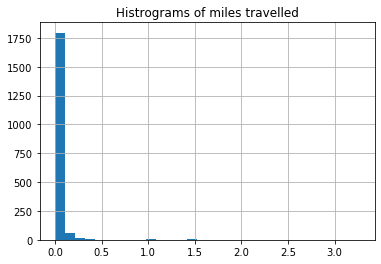

In [11]:
df_one_day_grp[df_one_day_grp['time_diff_hrs'] > 1]['distance_miles'].hist(bins=30)
plt.title('Histrograms of miles travelled')
plt.show()

### Cluster Scooters that are Stationary

In [17]:
# Define stationary
cond_stationary_1 = (df_one_day_grp['time_diff_hrs'] > 4)
cond_stationary_2 = (df_one_day_grp['distance_miles'] < 0.50)

cond_1_df = df_one_day_grp[cond_stationary_1]
stationary_df = df_one_day_grp[cond_stationary_1 & cond_stationary_2]
non_stationary_df = df_one_day_grp[~cond_stationary_2]

print('Percent of data that meet cond_1: {:.1f}%'.format(len(cond_1_df)/len(df_one_day_grp) * 100))
print('Percent of data that is stationary, given cond_1: {:.1f}%'.format(len(stationary_df)/len(cond_1_df) * 100))
print('Count of non-stationary scooters:', len(non_stationary_df))

Percent of data that meet cond_1: 28.8%
Percent of data that is stationary, given cond_1: 99.0%
Count of non-stationary scooters: 15


In [18]:
def generate_map(df, lat_col, long_col, m=None, color='crimson', center_loc=[38.95026, -77.09355]):
    if not m:
        m = folium.Map(location=center_loc)

    for i in range(0, len(df)-1):
        folium.Circle(
        location=[df[lat_col].iloc[i], df[long_col].iloc[i]],
        radius=5,
        color=color,
        fill=False,
        ).add_to(m)
    return m

In [25]:
print('Mapping stationary scooters')
m_stationary = generate_map(stationary_df, 'latitude_first', 'longitude_first')
m_stationary

Mapping stationary scooters


In [19]:
print('Mapping non-stationary scooters, first lat/long')
m_non_stationary_first = generate_map(non_stationary_df, 'latitude_first', 'longitude_first')
m_non_stationary_last = generate_map(non_stationary_df, 'latitude_last', 'longitude_last',
                                     m=m_non_stationary_first, color='blue')

Mapping non-stationary scooters, first lat/long


In [20]:
m_non_stationary_last

In [21]:
non_stationary_df.head()

,id,id_size,latitude_first,latitude_last,longitude_first,longitude_last,date_time_min,date_time_max,time_diff_hrs,distance_miles
435,1abf63b5-1125-416c-ab81-a0dfe8241ad2,128,38.858967,38.869370,-76.989243,-77.010712,2019-10-06 04:03:13,2019-10-06 23:37:30,19.571389,1.359437
692,2a2d2c71-591f-443e-b5b8-dfd91d816b91,56,38.907928,38.887981,-77.025414,-77.015968,2019-10-06 18:47:02,2019-10-06 23:48:19,5.021389,1.467722
863,35610f45-1d6d-44f3-aa53-ae4fcad649df,146,38.929909,38.912540,-77.010574,-77.026161,2019-10-06 04:03:08,2019-10-06 23:59:05,19.932500,1.462716
973,3c136dcf-f990-4bd8-84be-e3ac1c2b66b0,4,38.897408,38.904404,-77.082832,-77.069534,2019-10-06 16:40:18,2019-10-06 16:56:44,0.273889,0.862501
1124,45365b23-9e75-497a-b4ba-cec4b8d3826a,167,38.960709,38.930107,-77.022133,-76.975822,2019-10-06 04:03:05,2019-10-06 23:59:15,19.936111,3.263288


In [22]:
def generate_map_trip(df, lat_col_start, long_col_start, lat_col_end, long_col_end,
                     m=None, color='blue', center_loc=[38.95026, -77.09355]):
    if not m:
        print('creating a new map...')
        m = folium.Map(location=center_loc)

    for i in range(0, len(df)-1):
        # Add start and end point
        trip_start_end_point = [(df[lat_col_start].iloc[i], df[long_col_start].iloc[i]),
                          (df[lat_col_end].iloc[i], df[long_col_end].iloc[i])]
        folium.PolyLine(locations=trip_start_end_point, color=color, opacity=0.3).add_to(m)
        # Draw arrows 
        arrows = get_arrows(locations=trip_start_end_point, n_arrows=3)
        for arrow in arrows:
            arrow.add_to(m)
    return m

In [23]:
m_move = generate_map_trip(non_stationary_df, 'latitude_first', 'longitude_first',
                           'latitude_last', 'longitude_last')

creating a new map...


In [24]:
m_move

### Analyze multiple days of data

In [35]:
dates = get_dates_list('2019-10-05','2019-10-06')
df_multiple_days = get_many_days(df, dates)

print('Data cleaning (formats)')
int_cols = ['battery_level', 'estimated_range']
float_cols = ['latitude', 'longitude']

# Fix dtypes
df_multiple_days = df_multiple_days.astype({col: 'int32' for col in int_cols})
df_multiple_days = df_multiple_days.astype({col: 'float32' for col in float_cols})

df_multiple_days['date_time'] = df_multiple_days['Date'].map(str) + " " + df_multiple_days["Time"].map(str)
df_multiple_days['date_time'] = pd.to_datetime(df_multiple_days['date_time'])
df_multiple_days.head()

Data cleaning (formats)


,Date,Origin_Dist,Time,area_key,battery_level,bounty_id,captive,code,estimated_range,id,latitude,longitude,model,nest_id,vehicle_class,date_time
0,2019-10-05,0.580522,04:03:20,F461754DC547D80D5B8E77A5018FC6E8,49,None,False,None,6028,98b70819-82ef-4c0a-89ca-91cefa3550d1,38.935593,-77.082779,bd,None,scooter,2019-10-05 04:03:20
1,2019-10-05,0.827344,04:03:20,F461754DC547D80D5B8E77A5018FC6E8,45,388b9fa6-1497-400c-8670-33ddb51db837,False,None,5480,c0ed9b51-b4aa-4dcc-b77d-edc27b913219,38.947758,-77.093597,bd,None,scooter,2019-10-05 04:03:20
2,2019-10-05,0.861579,04:03:20,F461754DC547D80D5B8E77A5018FC6E8,65,None,False,None,7946,c5d989ca-e2b7-413b-9190-bb296fc6d6de,38.937988,-77.077812,bd,None,scooter,2019-10-05 04:03:20
3,2019-10-05,0.863961,04:03:20,F461754DC547D80D5B8E77A5018FC6E8,64,None,False,None,7809,64205c01-7fc2-4d55-a1af-7687614a209e,38.937946,-77.077759,bd,None,scooter,2019-10-05 04:03:20
4,2019-10-05,0.954965,04:03:20,F461754DC547D80D5B8E77A5018FC6E8,57,4057f61e-fcbb-4682-bcae-94f0fc414ee6,False,None,6987,e9f600a4-7a22-4796-8ffc-1188174c8fa1,38.948883,-77.087891,bd,None,scooter,2019-10-05 04:03:20


In [52]:
grpby_var = ['Date','id']
print('Summarize activity by', grpby_var)
# summary by bird id
df_multiple_days.sort_values(by='date_time', inplace=True)
df_multiple_days_grp = df_multiple_days.groupby(grpby_var).agg({'id':'size',
                                                    'latitude':['first', 'last'],
                                                    'longitude':['first', 'last'],
                                                    'date_time':['min', 'max']
                                                    }).reset_index()
# rename columns
df_multiple_days_grp.columns = grpby_var + ["_".join(x) for x in df_multiple_days_grp.columns[len(grpby_var):].ravel()]


Summarize activity by ['Date', 'id']


In [53]:
df_multiple_days_grp.head()

,Date,id,id_size,latitude_first,latitude_last,longitude_first,longitude_last,date_time_min,date_time_max
0,2019-10-05,00047559-9d86-4a9f-904d-b61a8575fcd4,13,38.880566,38.880566,-77.085831,-77.085831,2019-10-05 10:55:18,2019-10-05 12:00:43
1,2019-10-05,00110301-5d82-447e-b921-f4958bc5de71,7,38.911137,38.911137,-77.002579,-77.002579,2019-10-05 13:38:29,2019-10-05 14:10:59
2,2019-10-05,001a2d6a-ccf6-434f-8003-97a2c036da15,82,38.904209,38.903999,-77.062828,-77.063034,2019-10-05 09:11:51,2019-10-05 16:32:42
3,2019-10-05,005f846c-e758-4c8e-80bb-90dc1d182f9e,7,38.905323,38.905323,-77.058006,-77.058006,2019-10-05 16:32:42,2019-10-05 17:05:19
4,2019-10-05,006e2191-c2f7-4f2e-b0f6-4bfc934bff00,10,38.899529,38.899529,-77.023827,-77.023827,2019-10-05 17:59:40,2019-10-05 18:48:31


In [54]:
df_multiple_days_grp['time_diff_hrs'] = (df_multiple_days_grp['date_time_max'] -\
                                      df_multiple_days_grp['date_time_min'])/ np.timedelta64(1, 'h')
df_multiple_days_grp = compute_haverstine(df_multiple_days_grp, 'latitude_first', 'longitude_first',
                                    'latitude_last', 'longitude_last')

In [55]:
df_multiple_days_grp.head(2)

,Date,id,id_size,latitude_first,latitude_last,longitude_first,longitude_last,date_time_min,date_time_max,time_diff_hrs,distance_miles
0,2019-10-05,00047559-9d86-4a9f-904d-b61a8575fcd4,13,38.880566,38.880566,-77.085831,-77.085831,2019-10-05 10:55:18,2019-10-05 12:00:43,1.090278,0.0
1,2019-10-05,00110301-5d82-447e-b921-f4958bc5de71,7,38.911137,38.911137,-77.002579,-77.002579,2019-10-05 13:38:29,2019-10-05 14:10:59,0.541667,0.0


In [58]:
df_multiple_days_grp.groupby(['Date']).describe()

id_size                                                      \
             count       mean        std  min  25%   50%    75%    max   
Date                                                                     
2019-10-05  5298.0  30.284447  45.876866  1.0  4.0  11.0  34.75  221.0   
2019-10-06  4301.0  39.011393  51.527569  1.0  5.0  17.0  52.00  220.0   

           latitude_first             ... time_diff_hrs             \
                    count       mean  ...           75%        max   
Date                                  ...                            
2019-10-05         5298.0  38.894127  ...      3.076389  19.903611   
2019-10-06         4301.0  38.892647  ...      4.651111  19.936111   

           distance_miles                                                    \
                    count      mean       std  min  25%       50%       75%   
Date                                                                          
2019-10-05         5298.0  0.025888  0.152076  0.0  0.0  0.002534  0.014870   
2019-10-06         4301.0  0.025334  0.149249  0.0  0.0  0.002665  0.014844   

                      
                 max  
Date                  
2019-10-05  3.491935  
2019-10-06  6.062137  

[2 rows x 56 columns]

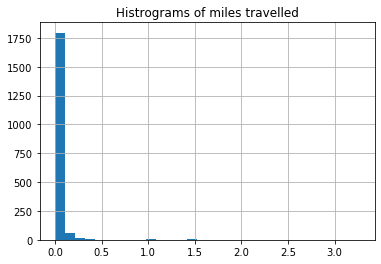

In [11]:
df_one_day_grp[df_one_day_grp['time_diff_hrs'] > 1]['distance_miles'].hist(bins=30)
plt.title('Histrograms of miles travelled')
plt.show()